In [46]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

seeds = []
for i in range(1, 101):
    seeds.append(i)


def time_to_minutes(timestr):
    # Handle '+1' suffix by removing it before parsing
    timestr = timestr.split('+')[0]  # Remove '+1' if present
    hh, mm = timestr.split(':')
    return int(hh) * 60 + int(mm)



def calculate_slack_for_scenario(scenario_data):
    """
    Calculate the slack metric for the given scenario.
    
    Slack is defined as:
        Slack = 1 - (total flight minutes in recovery period / total recovery period aircraft-minutes)
    
    A slack of 1 means no flights during recovery period.
    A slack of 0 means flights occupy the entire recovery period.
    """
    def time_to_minutes(timestr):
        # Handle '+1' suffix by removing it before parsing
        timestr = timestr.split('+')[0]  # Remove '+1' if present
        hh, mm = timestr.split(':')
        return int(hh) * 60 + int(mm)

    
    # Extract scenario start/end times
    # We assume the same date for start and end for simplicity.
    recovery_start_time_str = scenario_data["recovery_start_time"]  
    recovery_end_time_str = scenario_data["recovery_end_time"]      
    
    recovery_start_minutes = time_to_minutes(recovery_start_time_str)
    recovery_end_minutes = time_to_minutes(recovery_end_time_str)
    total_recovery_period_minutes = recovery_end_minutes - recovery_start_minutes
    
    total_aircraft = scenario_data["total_aircraft"]
    
    # Calculate total flight minutes within the recovery period
    flights = scenario_data["flights"]
    total_flights = len(flights)
    total_flight_minutes_in_recovery = 0
    total_flight_minutes_total = 0
    
    for flight_id, flight_data in flights.items():
        dep_time_str = flight_data["DepTime"]  
        arr_time_str = flight_data["ArrTime"] 
        
        dep_minutes = time_to_minutes(dep_time_str)
        arr_minutes = time_to_minutes(arr_time_str)
        
        total_flight_minutes_total += arr_minutes - dep_minutes
        overlap_start = max(dep_minutes, recovery_start_minutes)
        overlap_end = min(arr_minutes, recovery_end_minutes)
        
        if overlap_end > overlap_start:
            flight_overlap = overlap_end - overlap_start
        else:
            flight_overlap = 0
        
        total_flight_minutes_in_recovery += flight_overlap
    
    # Calculate total aircraft-minutes available during the recovery period
    total_recovery_aircraft_minutes = total_recovery_period_minutes * total_aircraft
    
    # Slack calculation
    if total_recovery_aircraft_minutes == 0:
        slack = 1.0
    else:
        slack = 1 - (total_flight_minutes_in_recovery / total_recovery_aircraft_minutes)
    
    return slack, total_flights, total_flight_minutes_total


def extract_disruption_stats(scenario_data):
    """
    Extract disruption statistics:
    - Count of fully disrupted (prob = 1.0)
    - Count of uncertain disruptions (0 < prob < 1.0)
    - Average probability across all aircraft (where an aircraft's probability is the max disruption probability it faces, 
      with 1.0 for fully disrupted and 0.0 if no disruption)
    - Average uncertainty probability (average of all disruptions where 0<prob<1.0, excluding 0 and 1)
    """
    disruptions_info = scenario_data.get('disruptions', {})
    disruptions_list = disruptions_info.get('disruptions', [])
    total_aircraft = disruptions_info.get('total_aircraft', 0)

    if total_aircraft == 0:
        # No aircraft or no disruptions
        return 0, 0, 0.0, 0.0

    fully_disrupted_count = sum(1 for d in disruptions_list if d.get('probability', 0.0) == 1.0)
    uncertain_disruptions = [d for d in disruptions_list if 0.0 < d.get('probability', 0.0) < 1.0]
    uncertain_count = len(uncertain_disruptions)

    aircraft_ids = scenario_data.get('aircraft_ids', [])
    ac_prob_map = {ac: 0.0 for ac in aircraft_ids}  
    
    for d in disruptions_list:
        ac_id = d.get('aircraft_id')
        p = d.get('probability', 0.0)
        # Keep the max probability for that aircraft
        if ac_id in ac_prob_map:
            ac_prob_map[ac_id] = max(ac_prob_map[ac_id], p)

    avg_ac_prob = sum(ac_prob_map.values()) / total_aircraft if total_aircraft > 0 else 0.0

    # Average uncertainty probability (only consider disruptions where 0<prob<1)
    if len(uncertain_disruptions) > 0:
        avg_uncertainty_prob = np.mean([d['probability'] for d in uncertain_disruptions])
    else:
        avg_uncertainty_prob = 0.0

    return fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertainty_prob, total_aircraft

# Path to the scenarios folder
scenario_folder_path = "../logs/scenarios/"
latest_folder = max(
    [f for f in os.listdir(scenario_folder_path) if f.startswith("scenario_folder_")],
    key=lambda x: int(x.split('_')[-1].replace('.json', ''))
)

# latest_folder = "scenario_folder_scenario_74.json" # Training/6ac-10-superdiverse

# latest_folder = "scenario_folder_scenario_77.json" # Training/6ac-10000-superdiverse
latest_folder = "scenario_folder_scenario_4.json" # Testing/6ac-700-diverse

file_path = os.path.join(scenario_folder_path, latest_folder)

# Extract scenario ID
scenario_id = file_path.split('_')[-1].split('.')[0]
print(f"Scenario ID: {scenario_id}")

# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract the scenarios from the JSON data
scenarios = data['outputs']


# Extract the data_folder (not strictly necessary for slack calculation, but we print it for context)
data_folder = data['data_folder']
print(f"Data Folder: {data_folder}")

# Calculate slack and disruption stats for each scenario and store in a list of dicts
results = []
for scenario_name, scenario_data in scenarios.items():
    scenario_slack, total_flights, total_flight_minutes_total = calculate_slack_for_scenario(scenario_data)
    fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertain_prob, total_aircraft = extract_disruption_stats(scenario_data)
    results.append({
        "Scenario": scenario_name,
        "ScenarioSlack": scenario_slack,
        "TotalFlights": total_flights,
        "TotalFlightMinutes": total_flight_minutes_total,
        "FullyDisruptedCount": fully_disrupted_count,
        "UncertainCount": uncertain_count,
        "AvgAircraftProbability": avg_ac_prob,
        "AvgUncertaintyProbability": avg_uncertain_prob,
        "TotalAircraft": total_aircraft
    })

# Convert results to DataFrame
scenarios_df = pd.DataFrame(results)
print(scenarios_df)

# Save the slack results to CSV
# output_file = os.path.join(scenario_folder_path, f"scenario_slack_metrics_{scenario_id}.csv")
# scenarios_df.to_csv(output_file, index=False)
# print(f"Slack metrics saved to {output_file}")


Scenario ID: 4
Data Folder: ../data/Testing/6ac-700-diverse/
                          Scenario  ScenarioSlack  TotalFlights  \
0    deterministic_na_Scenario_001       0.349048            21   
1    deterministic_na_Scenario_002       0.369713            21   
2    deterministic_na_Scenario_003       0.420513            13   
3    deterministic_na_Scenario_004       0.441493            16   
4    deterministic_na_Scenario_005       0.484896            14   
..                             ...            ...           ...   
695        mixed_high_Scenario_096       0.479683            15   
696        mixed_high_Scenario_097       0.460082            13   
697        mixed_high_Scenario_098       0.424324            20   
698        mixed_high_Scenario_099       0.407037            15   
699        mixed_high_Scenario_100       0.428228            18   

     TotalFlightMinutes  FullyDisruptedCount  UncertainCount  \
0                  4101                    2               0   
1     

<div class="alert alert-block alert-success">
</br>
</br>
</br>
<b>DONE: </b>MERGED DATASET
</br>
</br>
</br>
</br>
</div>

In [47]:
import os
import pandas as pd

scenario_folder_path = "../logs/scenarios/"
# unpack results_df
results_df = pd.read_csv(os.path.join(scenario_folder_path, f"t_results_df_in_rapport_seeds_{len(seeds)}.csv"))


# Merge scenario-level info from scenarios_df into results_df
merged_df = results_df.merge(scenarios_df, on='Scenario', how='left')

# Sort models in desired order
model_order = ['proactive', 'myopic', 'reactive', 'greedy_reactive']
merged_df['Model_Type'] = merged_df['Model'].str.extract('(' + '|'.join(model_order) + ')')
merged_df = merged_df.sort_values('Model_Type')
merged_df["Model"] = merged_df["Model_Type"]
merged_df = merged_df.drop('Model_Type', axis=1)
merged_df_backup = merged_df.copy()


# Update model names in merged_df
merged_df['Model'] = merged_df['Model'].apply(lambda x: 
    'DQN Proactive-U' if x.startswith('proactive') else
    'DQN Proactive-N' if x.startswith('myopic') else 
    'DQN Reactive' if x.startswith('reactive') else
    'Greedy Reactive' if x.startswith('greedy_reactive') else
    x
)

print("Inference Results (After Merging):")
print(merged_df)

# Save the merged results to CSV
merged_output_file = os.path.join(scenario_folder_path, f"scenario_inference_metrics_{scenario_id}.csv")
merged_df.to_csv(merged_output_file, index=False)
print(f"Inference results with scenario info saved to {merged_output_file}")



# print all column names
print("==== Columns: ====")
print(merged_df.columns)

print("==== amount of rows: ====")
print(len(merged_df))

print("==== Models: ====")
print(merged_df["Model"].unique())

print('===== len(seeds) =====')
print(len(merged_df['Seed'].unique()))

print('===== len(scenarios) =====')
print(len(merged_df['Scenario'].unique()))





Inference Results (After Merging):
                              Scenario            Model  Seed  TotalReward  \
139999     stochastic_low_Scenario_093  Greedy Reactive   100       -217.6   
130773          mixed_low_Scenario_063  Greedy Reactive    74      24786.2   
130772          mixed_low_Scenario_063  Greedy Reactive    73      24786.2   
130771          mixed_low_Scenario_063  Greedy Reactive    72      19799.3   
130770          mixed_low_Scenario_063  Greedy Reactive    71      19799.3   
...                                ...              ...   ...          ...   
222263  stochastic_medium_Scenario_085     DQN Reactive    64       9612.9   
222262  stochastic_medium_Scenario_085     DQN Reactive    63       -217.0   
222261  stochastic_medium_Scenario_085     DQN Reactive    62       -217.0   
222268  stochastic_medium_Scenario_085     DQN Reactive    69       9612.9   
35000      stochastic_low_Scenario_091     DQN Reactive     1        -90.8   

        TotalDelays  TotalCa

# Hypothesis 1: Solution method

In [48]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, shapiro, wilcoxon

ALPHA = 0.05

# -------------------------------------------------
# 1) FILTER, PIVOT
# -------------------------------------------------
df_two_methods = merged_df[merged_df['Model'].isin(['Greedy Reactive', 'DQN Reactive'])].copy()
df_pivot = df_two_methods.pivot_table(
    index=['Scenario', 'Seed'],
    columns='Model',
    values='TotalReward'
).dropna()

df_pivot.rename(
    columns={'Greedy Reactive': 'Greedy', 'DQN Reactive': 'DQN'},
    inplace=True
)

# -------------------------------------------------
# 2) BASIC STATS
# -------------------------------------------------
mean_greedy = df_pivot['Greedy'].mean()
std_greedy = df_pivot['Greedy'].std()
mean_dqn    = df_pivot['DQN'].mean()
std_dqn     = df_pivot['DQN'].std()

print(f"Greedy Reactive mean reward: {mean_greedy:.3f} (std={std_greedy:.3f})")
print(f"DQN Reactive    mean reward: {mean_dqn:.3f} (std={std_dqn:.3f})\n")

# -------------------------------------------------
# 3) NORMALITY CHECK (SHAPIRO–WILK)
# -------------------------------------------------
diff = df_pivot['DQN'] - df_pivot['Greedy']
shapiro_stat, shapiro_p = shapiro(diff)
print("Shapiro–Wilk test on (DQN - Greedy):")
print(f"  statistic={shapiro_stat:.4f}, p={shapiro_p:.4f}")

# -------------------------------------------------
# 4) CHOOSE & RUN THE APPROPRIATE TEST
# -------------------------------------------------
if shapiro_p < ALPHA:
    print("  => Non-normal difference (p < 0.05). We will use Wilcoxon because the data are not normally distributed.\n")

    # Wilcoxon signed-rank test
    w_stat, w_pval = wilcoxon(df_pivot['DQN'], df_pivot['Greedy'])
    print("Wilcoxon test (DQN vs. Greedy) on TotalReward:")
    print(f"  w-statistic={w_stat:.4f}, p-value={w_pval:.6f}")

    # Decision logic based on Wilcoxon
    p_val = w_pval  # We’ll use `p_val` for consistency with the code below.

else:
    print("  => Difference does not deviate strongly from normality (p >= 0.05). We will use the paired t-test.\n")

    # Paired t-test
    t_stat, t_pval = ttest_rel(df_pivot['DQN'], df_pivot['Greedy'])
    print("Paired t-test (DQN vs. Greedy) on TotalReward:")
    print(f"  t-statistic={t_stat:.4f}, p-value={t_pval:.6f}")

    # Decision logic based on t-test
    p_val = t_pval

# -------------------------------------------------
# 5) 95% CI OF DIFFERENCE
# -------------------------------------------------
mean_diff = diff.mean()
std_diff  = diff.std(ddof=1)
n         = len(diff)
se_diff   = std_diff / np.sqrt(n)
ci_lower  = mean_diff - 1.96 * se_diff
ci_upper  = mean_diff + 1.96 * se_diff

print(f"\nDifference (DQN - Greedy): mean={mean_diff:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

# -------------------------------------------------
# 6) EFFECT SIZE (Cohen's d)
# -------------------------------------------------
cohens_d = mean_diff / std_diff
print(f"Cohen's d (paired) = {cohens_d:.3f}\n")

# -------------------------------------------------
# 7) DECISION LOGIC
# -------------------------------------------------
# H0: DQN == Greedy
# H_alt: DQN > Greedy  (i.e., DQN is significantly better)

if p_val < ALPHA:
    print(f"p-value={p_val:.6f} < {ALPHA}, so we found a SIGNIFICANT DIFFERENCE.")
    if mean_diff > 0:
        print("  => DQN is HIGHER than Greedy. We reject H0 and ACCEPT the alt hypothesis")
        print("     that DQN is significantly better.")
    else:
        print("  => DQN is LOWER than Greedy. We reject H0 (no difference), but DQN < Greedy,")
        print("     which CONTRADICTS the alt hypothesis that DQN is better.")
        print("     So the difference is significant, but in the OPPOSITE direction of H_alt.")
else:
    print(f"p-value={p_val:.6f} >= {ALPHA}, so we fail to reject H0.")
    print("  => We do NOT have significant evidence of a difference in reward.")
    print("     (Cannot claim DQN is better based on these data.)")


Greedy Reactive mean reward: 32888.746 (std=28506.482)
DQN Reactive    mean reward: -4062.909 (std=23909.696)

Shapiro–Wilk test on (DQN - Greedy):
  statistic=0.9643, p=0.0000
  => Non-normal difference (p < 0.05). We will use Wilcoxon because the data are not normally distributed.

Wilcoxon test (DQN vs. Greedy) on TotalReward:
  w-statistic=78450579.0000, p-value=0.000000

Difference (DQN - Greedy): mean=-36951.655
95% CI: [-37219.218, -36684.091]
Cohen's d (paired) = -1.023

p-value=0.000000 < 0.05, so we found a SIGNIFICANT DIFFERENCE.
  => DQN is LOWER than Greedy. We reject H0 (no difference), but DQN < Greedy,
     which CONTRADICTS the alt hypothesis that DQN is better.
     So the difference is significant, but in the OPPOSITE direction of H_alt.


/Users/pieterbecking/Desktop/Boeing-ADM-DRL-Github/.venv2/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 70000.
  res = hypotest_fun_out(*samples, **kwds)


# Hypothesis 2: Action selection

In [49]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, shapiro, wilcoxon

# Significance level
ALPHA = 0.05

# 1) FILTER AND PIVOT
df_two_methods = merged_df[merged_df['Model'].isin(['DQN Proactive-N', 'DQN Reactive'])].copy()

# Pivot so each (Scenario, Seed) becomes a single row with columns [ProactiveN, Reactive]
df_pivot = df_two_methods.pivot_table(
    index=['Scenario', 'Seed'],
    columns='Model',
    values='TotalReward'
).dropna()

# For convenience, rename columns
df_pivot.rename(
    columns={'DQN Proactive-N': 'ProactiveN', 'DQN Reactive': 'Reactive'},
    inplace=True
)

# 2) BASIC STATS
mean_proactive = df_pivot['ProactiveN'].mean()
std_proactive  = df_pivot['ProactiveN'].std()
mean_reactive  = df_pivot['Reactive'].mean()
std_reactive   = df_pivot['Reactive'].std()

print(f"DQN Proactive-N mean reward: {mean_proactive:.3f} (std={std_proactive:.3f})")
print(f"DQN Reactive    mean reward: {mean_reactive:.3f} (std={std_reactive:.3f})\n")

# 3) CHECK NORMALITY
diff = df_pivot['ProactiveN'] - df_pivot['Reactive']
shapiro_stat, shapiro_p = shapiro(diff)
print("Shapiro–Wilk test on (ProactiveN - Reactive):")
print(f"  statistic={shapiro_stat:.4f}, p={shapiro_p:.4f}")

# Decide which test to use (t-test vs Wilcoxon) based on normality
if shapiro_p < ALPHA:
    print("  => Non-normal difference (p < 0.05). We will use the Wilcoxon test because the distribution is not normal.\n")
    test_name = "Wilcoxon"
    test_stat, p_val = wilcoxon(df_pivot['ProactiveN'], df_pivot['Reactive'])
else:
    print("  => Difference does not deviate strongly from normality (p >= 0.05).\n")
    test_name = "Paired t-test"
    test_stat, p_val = ttest_rel(df_pivot['ProactiveN'], df_pivot['Reactive'])

# 4) REPORT TEST RESULTS
print(f"{test_name} (ProactiveN vs. Reactive) on TotalReward:")
print(f"  statistic={test_stat:.4f}, p-value={p_val:.6f}")

# 5) 95% CI OF THE DIFFERENCE
mean_diff = diff.mean()
std_diff  = diff.std(ddof=1)
n         = len(diff)
se_diff   = std_diff / np.sqrt(n)
ci_lower  = mean_diff - 1.96 * se_diff
ci_upper  = mean_diff + 1.96 * se_diff

print(f"\nDifference (ProactiveN - Reactive): mean={mean_diff:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

# 6) EFFECT SIZE (Cohen's d for paired data)
cohens_d = mean_diff / std_diff
print(f"Cohen's d (paired) = {cohens_d:.3f}\n")

# 7) DECISION LOGIC
#   H0: No difference between ProactiveN and Reactive
#   H_alt: ProactiveN is significantly better (i.e., higher reward)
if p_val < ALPHA:
    print(f"p-value={p_val:.6f} < {ALPHA}, so we found a SIGNIFICANT DIFFERENCE.")
    if mean_diff > 0:
        print("  => ProactiveN > Reactive. Reject H0 and ACCEPT the alt hypothesis.")
        print("     DQN Proactive-N has a higher mean reward than DQN Reactive.\n")
    else:
        print("  => ProactiveN < Reactive. Reject H0, but ProactiveN is actually WORSE.")
        print("     This is significant but in the OPPOSITE direction of the alt hypothesis.\n")
else:
    print(f"p-value={p_val:.6f} >= {ALPHA}, so we FAIL to reject H0.")
    print("  => No statistically significant difference in the mean reward.\n")


DQN Proactive-N mean reward: 6198.375 (std=29111.820)
DQN Reactive    mean reward: -4062.909 (std=23909.696)

Shapiro–Wilk test on (ProactiveN - Reactive):
  statistic=0.9917, p=0.0000
  => Non-normal difference (p < 0.05). We will use the Wilcoxon test because the distribution is not normal.

Wilcoxon (ProactiveN vs. Reactive) on TotalReward:
  statistic=825400324.5000, p-value=0.000000

Difference (ProactiveN - Reactive): mean=10261.284
95% CI: [9995.512, 10527.055]
Cohen's d (paired) = 0.286

p-value=0.000000 < 0.05, so we found a SIGNIFICANT DIFFERENCE.
  => ProactiveN > Reactive. Reject H0 and ACCEPT the alt hypothesis.
     DQN Proactive-N has a higher mean reward than DQN Reactive.



/Users/pieterbecking/Desktop/Boeing-ADM-DRL-Github/.venv2/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 70000.
  res = hypotest_fun_out(*samples, **kwds)


# Hypothesis 3: Uncertainty indication

In [50]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, shapiro, wilcoxon
import statsmodels.api as sm

ALPHA = 0.05

# ---------------------------------------------------------
# 1) FILTER THE TWO METHODS & PIVOT ON REWARD
# ---------------------------------------------------------
df_two_methods = merged_df[merged_df['Model'].isin(['DQN Proactive-U', 'DQN Proactive-N'])].copy()

# Pivot so each (Scenario, Seed) is a row, columns = [ProactiveU, ProactiveN]
df_pivot_reward = df_two_methods.pivot_table(
    index=['Scenario', 'Seed'],
    columns='Model',
    values='TotalReward'
).dropna()

# Rename columns for convenience
df_pivot_reward.rename(
    columns={'DQN Proactive-U': 'ProactiveU', 'DQN Proactive-N': 'ProactiveN'},
    inplace=True
)

# Get the average probability (if you want to analyze that relationship)
df_prob = df_two_methods[['Scenario', 'Seed', 'AvgUncertaintyProbability']].drop_duplicates()
df_final = df_pivot_reward.merge(df_prob, on=['Scenario', 'Seed'], how='left')

# ---------------------------------------------------------
# 2) DESCRIPTIVE STATS
# ---------------------------------------------------------
mean_u = df_final['ProactiveU'].mean()
std_u  = df_final['ProactiveU'].std()
mean_n = df_final['ProactiveN'].mean()
std_n  = df_final['ProactiveN'].std()

print(f"DQN Proactive-U mean reward: {mean_u:.3f} (std={std_u:.3f})")
print(f"DQN Proactive-N mean reward: {mean_n:.3f} (std={std_n:.3f})\n")

# ---------------------------------------------------------
# 3) NORMALITY CHECK
# ---------------------------------------------------------
diff = df_final['ProactiveU'] - df_final['ProactiveN']
shapiro_stat, shapiro_p = shapiro(diff)
print("Shapiro–Wilk test on (ProactiveU - ProactiveN):")
print(f"  statistic={shapiro_stat:.4f}, p={shapiro_p:.4f}")

# Decide which test to use (t-test vs Wilcoxon) based on normality
if shapiro_p < ALPHA:
    print("  => Non-normal difference (p < 0.05). We will use the Wilcoxon test.\n")
    test_name = "Wilcoxon"
    test_stat, p_val = wilcoxon(df_final['ProactiveU'], df_final['ProactiveN'])
else:
    print("  => Difference does not deviate strongly from normality (p >= 0.05).\n")
    test_name = "Paired t-test"
    test_stat, p_val = ttest_rel(df_final['ProactiveU'], df_final['ProactiveN'])

# ---------------------------------------------------------
# 4) REPORT TEST RESULTS
# ---------------------------------------------------------
print(f"{test_name} (ProactiveU vs. ProactiveN) on TotalReward:")
print(f"  statistic={test_stat:.4f}, p-value={p_val:.6f}")

# ---------------------------------------------------------
# 5) 95% CI OF THE DIFFERENCE
# ---------------------------------------------------------
mean_diff = diff.mean()
std_diff  = diff.std(ddof=1)
n         = len(diff)
se_diff   = std_diff / np.sqrt(n)
ci_lower  = mean_diff - 1.96 * se_diff
ci_upper  = mean_diff + 1.96 * se_diff

print(f"\nDifference (U - N): mean={mean_diff:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

# ---------------------------------------------------------
# 6) EFFECT SIZE (Cohen's d)
# ---------------------------------------------------------
cohens_d = mean_diff / std_diff
print(f"Cohen's d (paired) = {cohens_d:.3f}\n")

# ---------------------------------------------------------
# 7) DECISION LOGIC
# ---------------------------------------------------------
# H0: No difference between Proactive-U and Proactive-N
# H_alt: Proactive-U is significantly better (i.e., higher reward)
if p_val < ALPHA:
    print(f"p-value={p_val:.6f} < {ALPHA}, so we found a SIGNIFICANT DIFFERENCE.")
    if mean_diff > 0:
        print("  => ProactiveU > ProactiveN. Reject H0 and ACCEPT H_alt.")
        print("     DQN Proactive-U has a higher mean reward than DQN Proactive-N.\n")
    else:
        print("  => ProactiveU < ProactiveN. Reject H0, but it's in the OPPOSITE direction.")
        print("     Proactive-U is actually WORSE than Proactive-N.\n")
else:
    print(f"p-value={p_val:.6f} >= {ALPHA}, so we FAIL to reject H0.")
    print("  => No statistically significant difference in the mean reward.\n")

# ---------------------------------------------------------
# 8) OPTIONAL: REGRESSION OF (U - N) vs. Probability
# ---------------------------------------------------------
X = sm.add_constant(df_final['AvgUncertaintyProbability'])  # add intercept
y = diff  # (ProactiveU - ProactiveN)

model = sm.OLS(y, X).fit()
print("Linear regression of (Proactive-U minus Proactive-N) vs. AvgUncertaintyProbability:")
print(model.summary())


DQN Proactive-U mean reward: 10186.831 (std=30907.585)
DQN Proactive-N mean reward: 6198.375 (std=29111.820)

Shapiro–Wilk test on (ProactiveU - ProactiveN):
  statistic=0.9924, p=0.0000
  => Non-normal difference (p < 0.05). We will use the Wilcoxon test.

Wilcoxon (ProactiveU vs. ProactiveN) on TotalReward:
  statistic=1116893103.0000, p-value=0.000000

Difference (U - N): mean=3988.457
95% CI: [3701.555, 4275.359]
Cohen's d (paired) = 0.103

p-value=0.000000 < 0.05, so we found a SIGNIFICANT DIFFERENCE.
  => ProactiveU > ProactiveN. Reject H0 and ACCEPT H_alt.
     DQN Proactive-U has a higher mean reward than DQN Proactive-N.

Linear regression of (Proactive-U minus Proactive-N) vs. AvgUncertaintyProbability:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   

/Users/pieterbecking/Desktop/Boeing-ADM-DRL-Github/.venv2/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 70000.
  res = hypotest_fun_out(*samples, **kwds)


# Hypothesis 4: Disruption scale

In [60]:
import pandas as pd
import statsmodels.api as sm

ALPHA = 0.05

# Hypothesis 4:
#   H0: Increasing disruption scale does NOT lead to significantly more cancellations/delays/swaps
#   H_alt: Increasing disruption scale leads to significantly more cancellations/delays/swaps

# ------------------------------------------------
# 1) PREPARE THE DATA
# ------------------------------------------------
df_four_methods = merged_df[merged_df['Model'].isin([
    'Greedy Reactive', 
    'DQN Reactive', 
    'DQN Proactive-N', 
    'DQN Proactive-U'
])].copy()

# Make sure the disruption scale is numeric
df_four_methods['DisruptionScaleNum'] = pd.to_numeric(df_four_methods['ActualDisruptedFlights'], errors='coerce')

# Define models and metrics to evaluate
models_of_interest = [
    'Greedy Reactive', 
    'DQN Reactive', 
    'DQN Proactive-N', 
    'DQN Proactive-U'
]

metrics = [
    'TotalCancelledFlights',
    'TotalDelays',
    'TailSwaps'
]

# ------------------------------------------------
# 2) FUNCTION TO TEST POSITIVE RELATIONSHIP
# ------------------------------------------------
def test_disruption_scale_effect(df, metric):
    """
    Tests if increasing disruption scale leads to significantly more of the metric
    Returns: (slope, p_value, significant_increase)
    """
    df = df.dropna(subset=[metric, 'DisruptionScaleNum'])
    
    if len(df) < 2:
        return (None, None, False)
    
    X = sm.add_constant(df['DisruptionScaleNum'])
    y = df[metric]
    
    model = sm.OLS(y, X).fit()
    
    slope = model.params['DisruptionScaleNum']
    p_val = model.pvalues['DisruptionScaleNum']
    
    # Check if there's a significant positive relationship
    significant_increase = (slope > 0) and (p_val < ALPHA)
    
    return (slope, p_val, significant_increase)

# ------------------------------------------------
# 3) TEST EACH MODEL & METRIC
# ------------------------------------------------
results = []

for model_name in models_of_interest:
    df_model = df_four_methods[df_four_methods['Model'] == model_name]
    
    print(f"\n=== Testing {model_name} ===")
    
    for metric in metrics:
        slope, p_val, significant_increase = test_disruption_scale_effect(df_model, metric)
        results.append((model_name, metric, slope, p_val, significant_increase))
        
        print(f"\nMetric: {metric}")
        if slope is None:
            print("  Not enough data to run test.")
            continue
            
        print(f"  Slope = {slope:.4f}")
        print(f"  p-value = {p_val:.6f}")
        
        if significant_increase:
            print(f"  => SIGNIFICANT INCREASE in {metric} with larger disruptions (p < {ALPHA})")
        else:
            if slope > 0:
                print(f"  => Positive but non-significant increase (p >= {ALPHA})")
            else:
                print("  => No evidence of increase")

# ------------------------------------------------
# 4) SUMMARIZE FINDINGS
# ------------------------------------------------
print("\n=== Summary of Findings ===")
for model_name in models_of_interest:
    model_results = [r for r in results if r[0] == model_name]
    significant_increases = sum(1 for r in model_results if r[4])
    
    print(f"\n{model_name}:")
    print(f"  {significant_increases} out of {len(metrics)} metrics show significant increases")
    
    for _, metric, slope, p_val, significant in model_results:
        if slope is not None:
            status = "SIGNIFICANT INCREASE" if significant else "no significant increase"
            print(f"  - {metric}: {status} (slope={slope:.4f}, p={p_val:.6f})")
        else:
            print(f"  - {metric}: insufficient data")



=== Testing Greedy Reactive ===

Metric: TotalCancelledFlights
  Slope = 0.4698
  p-value = 0.000000
  => SIGNIFICANT INCREASE in TotalCancelledFlights with larger disruptions (p < 0.05)

Metric: TotalDelays
  Slope = 9.7318
  p-value = 0.000000
  => SIGNIFICANT INCREASE in TotalDelays with larger disruptions (p < 0.05)

Metric: TailSwaps
  Slope = 0.5022
  p-value = 0.000000
  => SIGNIFICANT INCREASE in TailSwaps with larger disruptions (p < 0.05)

=== Testing DQN Reactive ===

Metric: TotalCancelledFlights
  Slope = 0.7402
  p-value = 0.000000
  => SIGNIFICANT INCREASE in TotalCancelledFlights with larger disruptions (p < 0.05)

Metric: TotalDelays
  Slope = 81.6244
  p-value = 0.000000
  => SIGNIFICANT INCREASE in TotalDelays with larger disruptions (p < 0.05)

Metric: TailSwaps
  Slope = 0.7707
  p-value = 0.000000
  => SIGNIFICANT INCREASE in TailSwaps with larger disruptions (p < 0.05)

=== Testing DQN Proactive-N ===

Metric: TotalCancelledFlights
  Slope = 0.5910
  p-value = 0

# Hypothesis 5: Schedule robustness

In [57]:
import pandas as pd
import statsmodels.api as sm

ALPHA = 0.05

# Hypothesis 5:
#   H0: Increasing schedule slack does NOT lead to significant differences 
#       among the 4 models across all 3 metrics (no consistent improvements).
#   H_alt: As schedule slack increases, performance (fewer cancellations/delays/swaps)
#          significantly improves for ALL 4 models (i.e., negative slope in all metrics).

# -----------------------------
# 1) PREPARE DATA
# -----------------------------
# We'll assume 'merged_df' has your data.
df_all = merged_df.copy()

# The 4 relevant models:
models_of_interest = [
    'Greedy Reactive', 
    'DQN Reactive', 
    'DQN Proactive-N', 
    'DQN Proactive-U'
]

# We'll check 3 metrics:
metrics = [
    'TotalCancelledFlights',
    'TotalDelays',
    'TailSwaps'
]

# We only keep rows from these 4 models to avoid confusion
df_all = df_all[df_all['Model'].isin(models_of_interest)].copy()

# Make sure 'ScenarioSlack' is numeric (0..1). If it's already float, that’s fine.
df_all['ScenarioSlack'] = pd.to_numeric(df_all['ScenarioSlack'], errors='coerce')

# -----------------------------
# 2) FUNCTION TO RUN LINEAR REGRESSION AND INTERPRET
# -----------------------------
def check_slack_effect(df, metric):
    """
    Runs a linear regression: metric ~ Slack
    Returns (slope, p_value, is_significantly_negative)
    """
    # Drop any missing rows
    df = df.dropna(subset=[metric, 'ScenarioSlack'])
    
    if len(df) < 2:
        # Not enough data for regression
        return (None, None, False)
    
    # Prepare X with intercept
    X = sm.add_constant(df['ScenarioSlack'])
    y = df[metric]
    
    # Fit OLS model
    model = sm.OLS(y, X).fit()
    
    # Extract slope & p-value for 'ScenarioSlack'
    slope = model.params['ScenarioSlack']
    p_val = model.pvalues['ScenarioSlack']
    
    # We want slope < 0 and p_val < ALPHA to say "significant decrease"
    is_signif_neg = (slope < 0) and (p_val < ALPHA)
    
    return (slope, p_val, is_signif_neg)

# -----------------------------
# 3) LOOP THROUGH EACH MODEL AND METRIC
# -----------------------------
all_good = True  # Will remain True only if ALL model-metric combos show significant negative slope

results_summary = []  # We'll collect data to print at the end

for m in models_of_interest:
    df_model = df_all[df_all['Model'] == m]
    
    for metric in metrics:
        slope, p_val, is_signif_neg = check_slack_effect(df_model, metric)
        
        # We'll store/print partial results now
        results_summary.append((m, metric, slope, p_val, is_signif_neg))
        
        print(f"Model={m}, Metric={metric}")
        if slope is None:
            print("  Not enough data to run regression.\n")
            all_good = False
            continue
        
        print(f"  Slope={slope:.4f}, p-value={p_val:.6f}")
        if is_signif_neg:
            print(f"  => Slack has a SIGNIFICANT NEGATIVE effect on '{metric}' for {m}.\n")
        else:
            # slope >= 0 or p_val >= ALPHA
            print(f"  => Slack does NOT show a significant negative effect on '{metric}' for {m}.\n")
            all_good = False

# -----------------------------
# 4) FINAL DECISION LOGIC
# -----------------------------
print("=== Final Decision on Hypothesis 5 ===")

if all_good:
    print("All 4 models show a SIGNIFICANT reduction in all 3 metrics as slack increases.")
    print("We REJECT H0 and ACCEPT H_alt: Slack helps all approaches significantly.")
else:
    print("At least one model or metric does NOT show a significant negative slope.")
    print("=> We FAIL to confirm that ALL approaches improve on ALL metrics.")
    print("Hence, we do NOT accept the alternative hypothesis (H_alt).")

# -----------------------------
# 5) (Optional) Detailed Summary
# -----------------------------
print("\n=== Detailed Summary ===")
for (m, metric, slope, p_val, is_signif_neg) in results_summary:
    if slope is not None:
        print(f"{m:<18} | {metric:<25} | slope={slope:8.3f} | p={p_val:7.5f} | significant_neg={is_signif_neg}")
    else:
        print(f"{m:<18} | {metric:<25} | NO DATA / REGRESSION FAILED")


Model=Greedy Reactive, Metric=TotalCancelledFlights
  Slope=-1.6474, p-value=0.000000
  => Slack has a SIGNIFICANT NEGATIVE effect on 'TotalCancelledFlights' for Greedy Reactive.

Model=Greedy Reactive, Metric=TotalDelays
  Slope=25.3842, p-value=0.000615
  => Slack does NOT show a significant negative effect on 'TotalDelays' for Greedy Reactive.

Model=Greedy Reactive, Metric=TailSwaps
  Slope=-0.2872, p-value=0.001123
  => Slack has a SIGNIFICANT NEGATIVE effect on 'TailSwaps' for Greedy Reactive.

Model=DQN Reactive, Metric=TotalCancelledFlights
  Slope=-1.6316, p-value=0.000000
  => Slack has a SIGNIFICANT NEGATIVE effect on 'TotalCancelledFlights' for DQN Reactive.

Model=DQN Reactive, Metric=TotalDelays
  Slope=-111.9766, p-value=0.000140
  => Slack has a SIGNIFICANT NEGATIVE effect on 'TotalDelays' for DQN Reactive.

Model=DQN Reactive, Metric=TailSwaps
  Slope=-2.5112, p-value=0.000000
  => Slack has a SIGNIFICANT NEGATIVE effect on 'TailSwaps' for DQN Reactive.

Model=DQN Proa

# Hypothesis 6: Scenario size scaling

                            OLS Regression Results                            
Dep. Variable:           ScenarioTime   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                 3.123e+04
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:00:21   Log-Likelihood:             3.3558e+05
No. Observations:              280000   AIC:                        -6.711e+05
Df Residuals:                  279992   BIC:                        -6.711e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

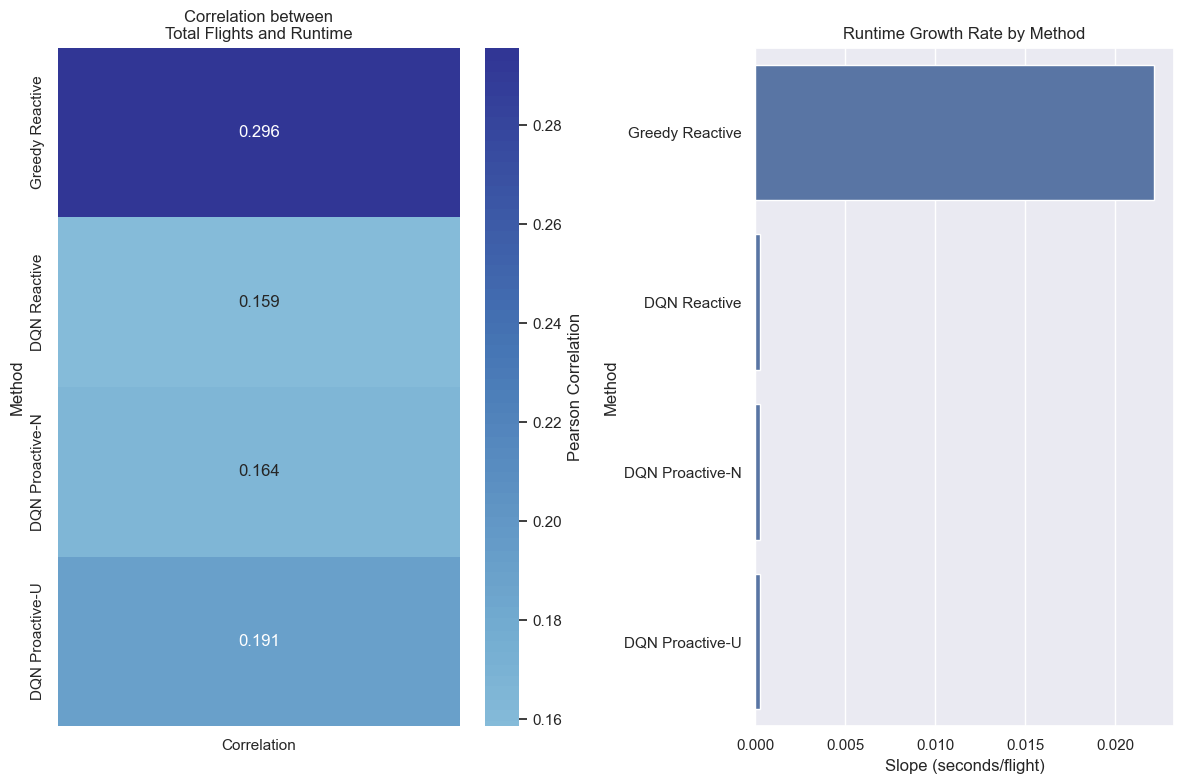

In [65]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

ALPHA = 0.05

# Hypothesis 6:
#   H0: No significant difference in how DRL vs. Greedy scale in runtime.
#   H_alt: DRL-based methods have a SLOWER growth in runtime as #Flights increases.

# ------------------------------------------------
# 1) PREPARE DATA
# ------------------------------------------------
df_methods = merged_df.copy()

# We'll keep only the four relevant methods if needed
df_methods = df_methods[df_methods['Model'].isin([
    'Greedy Reactive',
    'DQN Reactive',
    'DQN Proactive-N',
    'DQN Proactive-U'
])].copy()

# Suppose 'Runtime' is a column in seconds or minutes, and 'TotalFlights' is the scenario size
# Convert them to numeric if necessary
df_methods['ScenarioTime'] = pd.to_numeric(df_methods['ScenarioTime'], errors='coerce')
df_methods['TotalFlights'] = pd.to_numeric(df_methods['TotalFlights'], errors='coerce')

# Drop missing
df_methods = df_methods.dropna(subset=['ScenarioTime', 'TotalFlights'])

# Make 'Method' a categorical variable
df_methods['Method'] = df_methods['Model'].astype('category')

# Ensure "Greedy Reactive" is the REFERENCE category in the model
df_methods['Method'] = df_methods['Method'].cat.reorder_categories([
    'Greedy Reactive',
    'DQN Reactive',
    'DQN Proactive-N',
    'DQN Proactive-U'
], ordered=True)

# ------------------------------------------------
# 2) FIT LINEAR MODEL WITH INTERACTION
# ------------------------------------------------
# We'll do: Runtime ~ C(Method)*TotalFlights
# This gives us a baseline slope for 'Greedy Reactive' 
# plus slope differences for the DRL methods.
model = ols("ScenarioTime ~ C(Method)*TotalFlights", data=df_methods).fit()
print(model.summary())

# The key parameters of interest:
#   - 'TotalFlights' => slope for the reference (Greedy Reactive)
#   - 'C(Method)[T.DQN Reactive]:TotalFlights' => slope difference for DQN Reactive vs. Greedy
#   - 'C(Method)[T.DQN Proactive-N]:TotalFlights' => slope difference for DQN Proactive-N vs. Greedy
#   - 'C(Method)[T.DQN Proactive-U]:TotalFlights' => slope difference for DQN Proactive-U vs. Greedy

# ------------------------------------------------
# 3) EXTRACT SLOPES AND TEST IF DRL < GREEDY
# ------------------------------------------------
params = model.params
pvalues = model.pvalues

# The slope for Greedy:
greedy_slope = params['TotalFlights']
greedy_slope_p = pvalues['TotalFlights']

# For each DRL method, the total slope = (greedy_slope + difference_term)
# We'll check if "difference_term" is negative enough to make the DRL slope < Greedy
# and if that difference is statistically significant.
methods_drl = ['DQN Reactive', 'DQN Proactive-N', 'DQN Proactive-U']

# We'll track whether *all* DRL slopes are significantly lower
all_drl_slopes_lower = True

for m in methods_drl:
    # The difference in slope for method m
    diff_key = f"C(Method)[T.{m}]:TotalFlights"
    if diff_key not in params:
        # Just in case the design changed
        print(f"Method '{m}' not found in model parameters!")
        all_drl_slopes_lower = False
        continue

    slope_diff = params[diff_key]
    p_val_diff = pvalues[diff_key]

    # The DRL slope is:
    slope_drl = greedy_slope + slope_diff

    print(f"\n--- {m} vs. Greedy Reactive ---")
    print(f"Slope (Greedy)        = {greedy_slope:.6f}")
    print(f"Slope difference      = {slope_diff:.6f} (p={p_val_diff:.6g})")
    print(f"  => Implied slope(DRL) = {slope_drl:.6f}")

    # We want slope_drl < greedy_slope AND p_val_diff < ALPHA 
    # to say "significantly smaller slope"
    # Actually, because the reference slope can also be uncertain, 
    # a simpler approach is to see if slope_diff < 0 and p_val_diff < 0.05 
    # to say the difference from Greedy is significant and negative.

    if (slope_diff < 0) and (p_val_diff < ALPHA):
        # This means the DRL slope is significantly lower than Greedy
        print("  => This DRL method has a significantly LOWER growth rate than Greedy.")
    else:
        print("  => This DRL method does NOT show a significantly lower slope than Greedy.")
        all_drl_slopes_lower = False

# ------------------------------------------------
# 4) DECISION LOGIC ON HYPOTHESIS
# ------------------------------------------------
print("\n=== Hypothesis 6 Decision ===")
if all_drl_slopes_lower:
    print("All DRL-based methods have a significantly lower runtime slope than Greedy.")
    print("We REJECT H0 and ACCEPT H_alt => DRL has slower growth in runtime with scenario size.")
else:
    print("At least one DRL method does NOT have a significantly lower slope than Greedy.")
    print("We FAIL to confirm that DRL-based methods scale better in all cases => FAIL to reject H0.")

# ------------------------------------------------
# 5) VISUALIZATION
# ------------------------------------------------
# Create correlation matrix between TotalFlights and ScenarioTime for each method
plt.figure(figsize=(12, 8))
# Create subplot grid - one for correlation plot, one for trend summary
from matplotlib import gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1])

# Correlation plot
ax1 = plt.subplot(gs[0])
method_correlations = []
for method in ['Greedy Reactive'] + methods_drl:
    mask = df_methods['Method'] == method
    corr = pearsonr(df_methods[mask]['TotalFlights'], 
                    df_methods[mask]['ScenarioTime'])[0]
    method_correlations.append({'Method': method, 
                              'Correlation': corr})

corr_df = pd.DataFrame(method_correlations)
corr_df = corr_df.set_index('Method')

sns.heatmap(corr_df, annot=True, cmap='RdYlBu', center=0,
            fmt='.3f', ax=ax1, cbar_kws={'label': 'Pearson Correlation'})
ax1.set_title('Correlation between\nTotal Flights and Runtime')

# Trend summary
ax2 = plt.subplot(gs[1])
slopes = []
for method in ['Greedy Reactive'] + methods_drl:
    mask = df_methods['Method'] == method
    z = np.polyfit(df_methods[mask]['TotalFlights'], 
                   df_methods[mask]['ScenarioTime'], 1)
    slopes.append({'Method': method, 'Slope': z[0]})

slope_df = pd.DataFrame(slopes)
sns.barplot(data=slope_df, x='Slope', y='Method', ax=ax2)
ax2.set_title('Runtime Growth Rate by Method')
ax2.set_xlabel('Slope (seconds/flight)')

plt.tight_layout()
plt.show()
